In [5]:
#导入数据集
import torchtext
from torchtext.vocab import GloVe
TEXT = torchtext.data.Field(lower=True,fix_length=200,batch_first=True)
LABEL = torchtext.data.Field(sequential=False)
train,valid,test = torchtext.datasets.SST.splits(TEXT,LABEL)
TEXT.build_vocab(train,vectors=GloVe(name='6B',dim=100),max_size=20000,min_freq=10)
LABEL.build_vocab(train)
import torch
from torch import nn
vocab = TEXT.vocab.vectors
print(vocab.shape)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

torch.Size([1682, 100])


1.梗概：代码主要分为三个部分 GloVe/Random + RNN(LSTM) ; GloVe/Random + RNN(LSTM) + Attention ;
GloVe/Random + Transformer + Attention. (最后都有Linear分类器)
2.拓展：采用torch.nn.init.xavier_uniform_来初始化参数; 采用Adam优化器; 每个部分都进行网格搜索寻找最佳参数(batch_size和学习率lr)
3.结果：三个部分的最佳参数和测试结果为：
GloVe + RNN(LSTM): batch=4,lr=0.001  accuracy=63.801%
Random + RNN(LSTM): batch=32,lr=0.01 accuracy=60.136%
GloVe + RNN(LSTM) + Attention: batch=4,lr=0.001 accuracy=64.525%
Random + RNN(LSTM) + Attention: batch=64,lr=0.001 accuracy=60.217%
GloVe + Transformer + Attention: batch=32,lr=0.001 accuracy=61.991%
Random + Transformer + Attention: batch=4,lr=0.01 accuracy=41.267%
4.未解决问题: 如何通过多卡加速计算

In [2]:
#device
import torch
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
#train function
def train_data(train_iter,net,L,epoches,devices,lr):
    #net = nn.DataParallel(net, device_ids=devices).to(devices[0])  unsolved~
    net = net.to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=lr) #采用Adam优化器
    for epoch in range(epoches):
        net.train()
        total_loss = 0
        for batch in train_iter:
            trainer.zero_grad()
            inputs, labels = batch.text, batch.label #根据每一批次得数据
            inputs = inputs.to(devices[0])  #导入GPU
            labels = labels.to(devices[0])
            outputs = net(inputs)
            loss = L(outputs, labels)
            loss.backward()
            trainer.step()
        total_loss += loss.item()
    return (total_loss / len(train_iter))


#test function
def test_data(iter,net,devices):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in iter:
            inputs, labels = batch.text, batch.label
            inputs = inputs.to(devices[0])
            labels = labels.to(devices[0])
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (100 * correct / total)
    
#use GPU
def try_all_gpus(): 
    devices = [torch.device(f'cuda:{i}')
        for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]


In [7]:
#GloVe/Random+RNN(LSTM)+Linear
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
        bidirectional=True) #双向LSTM
        self.decoder = nn.Linear(4 * num_hiddens, 4)
    def forward(self, inputs):
        device = inputs.device
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # outputs的形状是(时间步数, 批量⼤⼩, 2*隐藏单元数)
        outputs, _ = self.encoder(embeddings)
        # encoding连接后就是(批量大小, 4*隐藏单元数)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        outs = outs.to(device)
        return outs

#初始化参数 三个部分共有
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

#设置超参数
embed_size, num_hiddens, num_layers = 100, 100, 2
L = nn.CrossEntropyLoss()

devices = try_all_gpus()

#batches和lrs, 3部分一致
batches = [4,8,16,32,64]
lrs = [0.001,0.01,0.1,1]
result1 = np.zeros((5,4))
result2 = np.zeros((5,4))
Loss1 = np.zeros((5,4))
Loss2 = np.zeros((5,4))
i,j=0,0
for batch in batches:
    j=0
    #裁剪
    train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits((train,valid,test),batch_size=batch)
    for lr in lrs:
        net1 = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
        net1.apply(init_weights);
        #GloVe就导入之前生成的vocab矩阵
        net1.embedding.weight.data.copy_(vocab)
        net1.embedding.weight.requires_grad = False
        lo1 = train_data(train_iter,net1,L,5,devices,lr)
        r1 = test_data(test_iter,net1,devices)
        result1[i][j] = r1
        Loss1[i][j] = lo1

        net2 = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
        net2.apply(init_weights);
        net2.embedding.weight.requires_grad = False
        lo2 = train_data(train_iter,net2,L,5,devices,lr)
        r2 = test_data(test_iter,net2,devices)
        result2[i][j] = r2
        Loss2[i][j] = lo2
        print("In GloVe,batch= ",batch,",lr= ",lr,",loss= ",lo1,",accuracy= ",r1)
        print("In Random,batch= ",batch,",lr= ",lr,",loss= ",lo2,",accuracy= ",r2)
        j +=1
    i += 1
    


In GloVe,batch=  4 ,lr=  0.001 ,loss=  6.730026436432471e-05 ,accuracy=  63.800904977375566
In Random,batch=  4 ,lr=  0.001 ,loss=  0.0003287747000040633 ,accuracy=  59.411764705882355
In GloVe,batch=  4 ,lr=  0.01 ,loss=  0.0004175574368751897 ,accuracy=  43.755656108597286
In Random,batch=  4 ,lr=  0.01 ,loss=  0.0005024886421496502 ,accuracy=  49.547511312217196
In GloVe,batch=  4 ,lr=  0.1 ,loss=  0.0012354772635613488 ,accuracy=  37.782805429864254
In Random,batch=  4 ,lr=  0.1 ,loss=  0.0003185683533493499 ,accuracy=  41.13122171945702
In GloVe,batch=  4 ,lr=  1 ,loss=  0.03403142507603106 ,accuracy=  41.13122171945702
In Random,batch=  4 ,lr=  1 ,loss=  0.03155418281698048 ,accuracy=  40.678733031674206
In GloVe,batch=  8 ,lr=  0.001 ,loss=  0.0007698130741548002 ,accuracy=  63.665158371040725
In Random,batch=  8 ,lr=  0.001 ,loss=  0.0005715023935510871 ,accuracy=  59.457013574660635
In GloVe,batch=  8 ,lr=  0.01 ,loss=  0.0012151524145504954 ,accuracy=  63.12217194570136
In Ra

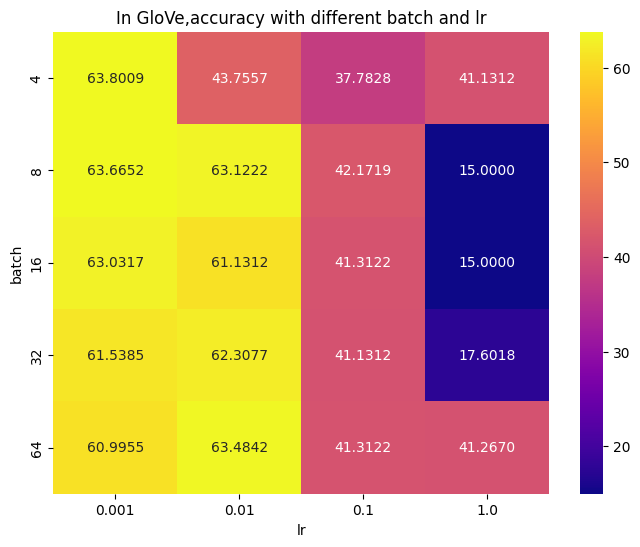

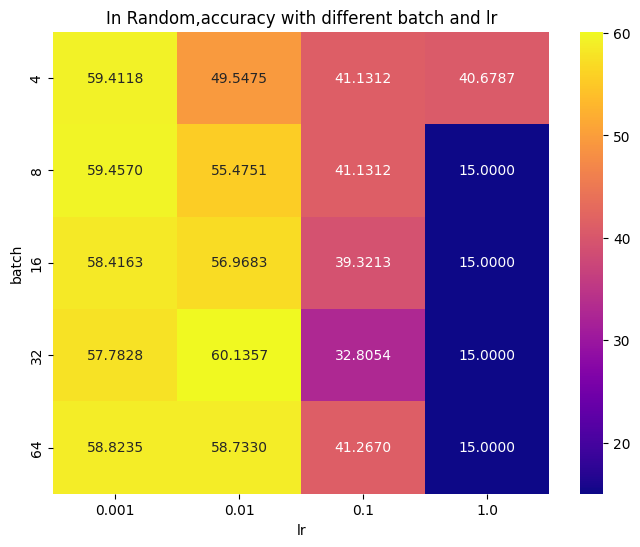

In [8]:
#绘制热度图，直观反映各参数下的结果，如果正确率太低会给予最低下限；处理梯度消失或爆炸而loss为nan的情况
import pandas as pd
result1 = np.where(result1 < 15,15,result1)
result2 = np.where(result2 < 15,15,result2)
df1 = pd.DataFrame(data=result1, index=batches, columns=lrs)
plt.figure(figsize=(8, 6))
sns.heatmap(df1, annot=True, fmt=".4f", cmap="plasma", cbar=True)
plt.title("In GloVe,accuracy with different batch and lr")
plt.xlabel("lr")
plt.ylabel("batch")
plt.show()

df2 = pd.DataFrame(data=result2, index=batches, columns=lrs)
plt.figure(figsize=(8, 6))
sns.heatmap(df2, annot=True, fmt=".4f", cmap="plasma", cbar=True)
plt.title("In Random,accuracy with different batch and lr")
plt.xlabel("lr")
plt.ylabel("batch")
plt.show()

In [16]:
#GloVe/Random+RNN(LSTM)+Attention+Linear
class BiRNN2(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,num_layers,num_heads, **kwargs):
        super(BiRNN2, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 将bidirectional设置为True以获取双向循环神经⽹络
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,bidirectional=True)
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.decoder = nn.Linear(4 * num_hiddens, 4)
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        #context这里是(时间步数, 批量大小, 1*隐藏单元数) 要先扩展
        context, _ = self.attention(embeddings, embeddings, embeddings)
        context = context.repeat(1, 1, 2)
        attended_output = outputs + context
        #相加后再输出
        encoding = torch.cat((attended_output[0], attended_output[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs
    

#超参
embed_size, num_hiddens, num_layers,num_heads = 100, 100, 2, 2

#下面是一样的
result3 = np.zeros((5,4))
result4 = np.zeros((5,4))
Loss3 = np.zeros((5,4))
Loss4 = np.zeros((5,4))
i,j=0,0
for batch in batches:
    j=0
    train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits((train,valid,test),batch_size=batch)
    for lr in lrs:
        net1 = BiRNN2(len(vocab), embed_size, num_hiddens, num_layers,num_heads)
        net1.apply(init_weights);
        net1.embedding.weight.data.copy_(vocab)
        net1.embedding.weight.requires_grad = False
        lo3 = train_data(train_iter,net1,L,5,devices,lr)
        r1 = test_data(test_iter,net1,devices)
        result3[i][j] = r1
        Loss3[i][j] = lo3

        net2 = BiRNN2(len(vocab), embed_size, num_hiddens, num_layers,num_heads)
        net2.apply(init_weights);
        net2.embedding.weight.requires_grad = False
        lo4 = train_data(train_iter,net2,L,5,devices,lr)
        r2 = test_data(test_iter,net2,devices)
        result4[i][j] = r2
        Loss4[i][j] = lo4

        print("In GloVe,batch= ",batch,",lr= ",lr,",loss= ",lo3,",accuracy= ",r1)
        print("In Random,batch= ",batch,",lr= ",lr,",loss= ",lo4,",accuracy= ",r2)
        j +=1
    i += 1
    


In GloVe,batch=  4 ,lr=  0.001 ,loss=  0.00016033102510573712 ,accuracy=  64.52488687782805
In Random,batch=  4 ,lr=  0.001 ,loss=  0.0005405572023284569 ,accuracy=  58.3710407239819
In GloVe,batch=  4 ,lr=  0.01 ,loss=  0.00032992973533016017 ,accuracy=  58.32579185520362
In Random,batch=  4 ,lr=  0.01 ,loss=  0.0020185269220044997 ,accuracy=  44.07239819004525
In GloVe,batch=  4 ,lr=  0.1 ,loss=  0.12695696827177697 ,accuracy=  41.13122171945702
In Random,batch=  4 ,lr=  0.1 ,loss=  nan ,accuracy=  0.0
In GloVe,batch=  4 ,lr=  1 ,loss=  57.46457309222846 ,accuracy=  39.95475113122172
In Random,batch=  4 ,lr=  1 ,loss=  17970.850187265918 ,accuracy=  39.23076923076923
In GloVe,batch=  8 ,lr=  0.001 ,loss=  0.0008244042316179597 ,accuracy=  62.76018099547511
In Random,batch=  8 ,lr=  0.001 ,loss=  0.0003719683666800738 ,accuracy=  60.04524886877828
In GloVe,batch=  8 ,lr=  0.01 ,loss=  0.001038323850667432 ,accuracy=  60.723981900452486
In Random,batch=  8 ,lr=  0.01 ,loss=  0.00240507

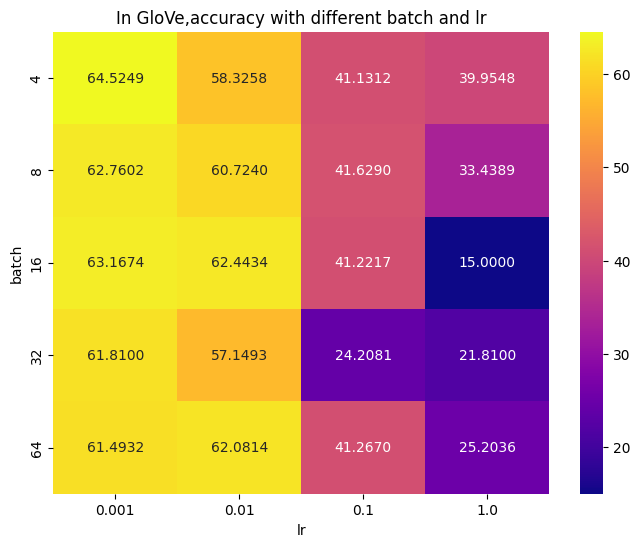

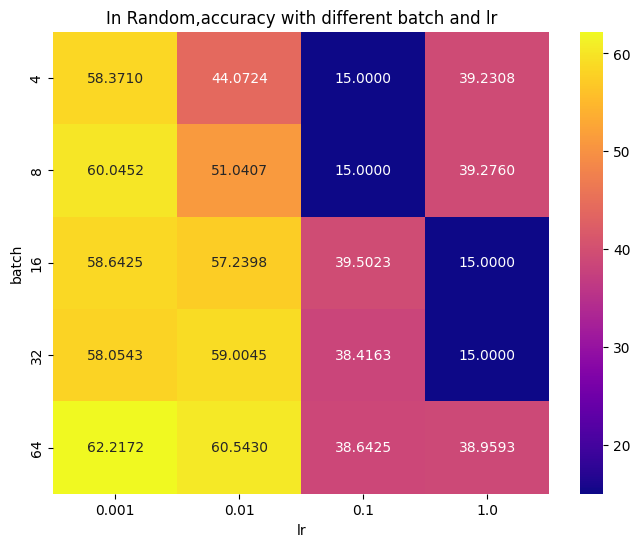

In [17]:
#一样的绘图
result3 = np.where(result3 < 15,15,result3)
result4 = np.where(result4 < 15,15,result4)
df3 = pd.DataFrame(data=result3, index=batches, columns=lrs)
plt.figure(figsize=(8, 6))
sns.heatmap(df3, annot=True, fmt=".4f", cmap="plasma", cbar=True)
plt.title("In GloVe,accuracy with different batch and lr")
plt.xlabel("lr")
plt.ylabel("batch")
plt.show()

df4 = pd.DataFrame(data=result4, index=batches, columns=lrs)
plt.figure(figsize=(8, 6))
sns.heatmap(df4, annot=True, fmt=".4f", cmap="plasma", cbar=True)
plt.title("In Random,accuracy with different batch and lr")
plt.xlabel("lr")
plt.ylabel("batch")
plt.show()

In GloVe,batch=  4 ,lr=  0.001 ,loss=  0.00043199272749575783 ,accuracy=  41.13122171945702
In Random,batch=  4 ,lr=  0.001 ,loss=  0.0005127094434888176 ,accuracy=  41.13122171945702
In GloVe,batch=  4 ,lr=  0.01 ,loss=  0.0004392544484317079 ,accuracy=  41.13122171945702
In Random,batch=  4 ,lr=  0.01 ,loss=  0.0004596275169304694 ,accuracy=  41.26696832579186
In GloVe,batch=  4 ,lr=  0.1 ,loss=  0.17226155598958334 ,accuracy=  41.26696832579186
In Random,batch=  4 ,lr=  0.1 ,loss=  4.82872093605638e-05 ,accuracy=  41.26696832579186
In GloVe,batch=  4 ,lr=  1 ,loss=  339.1385767790262 ,accuracy=  41.26696832579186
In Random,batch=  4 ,lr=  1 ,loss=  90.42134831460675 ,accuracy=  41.26696832579186
In GloVe,batch=  8 ,lr=  0.001 ,loss=  0.0012329234166091748 ,accuracy=  41.13122171945702
In Random,batch=  8 ,lr=  0.001 ,loss=  0.0010415400458632337 ,accuracy=  41.13122171945702
In GloVe,batch=  8 ,lr=  0.01 ,loss=  0.0010720143157444643 ,accuracy=  41.26696832579186
In Random,batch=  8

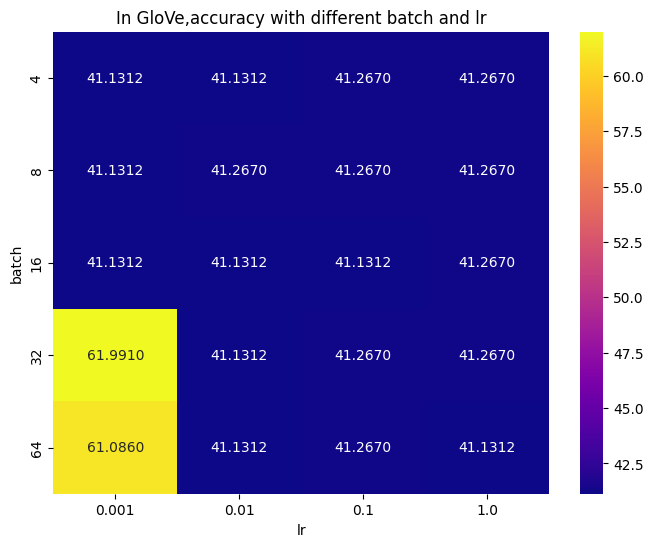

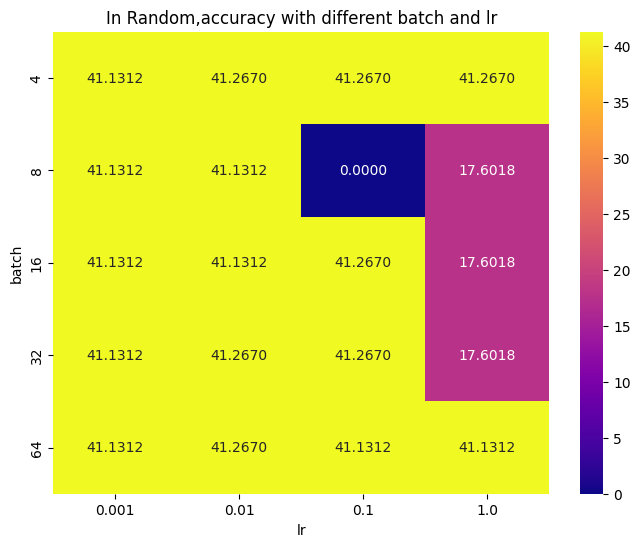

In [19]:
#GloVe/Random+transformer+attention
vocab = TEXT.vocab.vectors
class TransformerWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, num_heads, **kwargs):
        super(TransformerWithAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        #调用nn.Transformer
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
        )
        self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.decoder = nn.Linear(embed_size, 4)
        
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        transformer_output = self.transformer(embeddings, embeddings)
        #这里的transfmer_output和attention_output形状一样，都是(时间, 批量,embed_size)
        attention_output, _ = self.attention(transformer_output, transformer_output, transformer_output)
        #这次换为均值输出
        encoding = attention_output.mean(dim=0)  
        outs = self.decoder(encoding)
        return outs

# Define the model with your parameters
embed_size, num_hiddens, num_layers, num_heads = 100, 100, 2, 1
result5 = np.zeros((5,4))
result6 = np.zeros((5,4))
Loss5 = np.zeros((5,4))
Loss6 = np.zeros((5,4))
i,j=0,0
for batch in batches:
    j=0
    train_iter, valid_iter, test_iter = torchtext.data.BucketIterator.splits((train,valid,test),batch_size=batch)
    for lr in lrs:
        net1 = TransformerWithAttention(len(vocab), embed_size, num_layers,num_heads)
        net1.apply(init_weights);
        net1.embedding.weight.data.copy_(vocab)
        net1.embedding.weight.requires_grad = False
        lo5 = train_data(train_iter,net1,L,5,devices,lr)
        r1 = test_data(test_iter,net1,devices)
        result5[i][j] = r1
        Loss5[i][j] = lo5

        net2 = TransformerWithAttention(len(vocab), embed_size, num_layers,num_heads)
        net2.apply(init_weights);
        net2.embedding.weight.requires_grad = False
        lo6 = train_data(train_iter,net2,L,5,devices,lr)
        r2 = test_data(test_iter,net2,devices)
        result6[i][j] = r2
        Loss6[i][j] = lo6
        print("In GloVe,batch= ",batch,",lr= ",lr,",loss= ",lo5,",accuracy= ",r1)
        print("In Random,batch= ",batch,",lr= ",lr,",loss= ",lo6,",accuracy= ",r2)
        
        j +=1
    i += 1
    


df5 = pd.DataFrame(data=result5, index=batches, columns=lrs)
plt.figure(figsize=(8, 6))
sns.heatmap(df5, annot=True, fmt=".4f", cmap="plasma", cbar=True)
plt.title("In GloVe,accuracy with different batch and lr")
plt.xlabel("lr")
plt.ylabel("batch")
plt.show()

df6 = pd.DataFrame(data=result6, index=batches, columns=lrs)
plt.figure(figsize=(8, 6))
sns.heatmap(df6, annot=True, fmt=".4f", cmap="plasma", cbar=True)
plt.title("In Random,accuracy with different batch and lr")
plt.xlabel("lr")
plt.ylabel("batch")
plt.show()
